***

<center><u><H1>Clustering: hierarchical clustering</H1></u></center>

***

Il clustering è una tecnica unsupervised di Machine Learning, ovvero non mira a predire il valore o la classe di una variabile dipendente ma a raggruppare i dati in cluster basandosi su una qualche misura di similarità.

Le tecniche di clustering si dividono in:
- **partition-based**: tecnica abbastanza efficiente che produce cluster di forma orientativamente sferica, come il k-means;
- **hierarchical**: produce un albero di cluster, molto efficiente con dataset piccoli (può essere agglomerativa o divisiva);
- **density-based**: produce cluster di dimensione arbitraria, molto utili quando si ha un dataset rumoroso o cluster immersi in altri cluster, ad esempio il DBSCAN.

In questo notebook, ricorriamo al clustering gerarchico. Lo Hierarchical Clustering (HC) può essere di tipo allgomerativo o divisivo. In questa lezione, consideriamo quello agglomerativo, ovvero:
- si inizia con $N$ cluster per $N$ osservazioni, cioè ogni osservazione è in un cluster separato
- si uniscono i due cluster più vicini
- si itera fino a che non si ottiene un unico cluster
- i cluster vengono identificati con un criterio appropriato a valle dell'algoritmo

Questo approccio di clustering quindi crea una gerarchia di cluster, non una singola soluzione. Starà poi a noi identificare a che livello tagliare l'albero per ottenere la lista di cluster. Per il calcolo della distanza tra due cluster, come discusso, si hanno vari approcci:
- **single-linkage**: punti più vicini
- **complete-linkage**: punti più lontani
- **centroid linkage**: centroidi
- **average linkage**: distanza media
 

# 1 Analisi del dataset e pre-processing

## 1.1 Importazione

Prima di tutto importiamo i moduli necessari:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # feature scaling
from sklearn.cluster import AgglomerativeClustering  # clustering
from scipy.cluster import hierarchy  # clustering
from sklearn.metrics import silhouette_score  # metriche

sns.set_style("whitegrid")
sns.set_palette("pastel")

### 1.2 Caratteristiche del dataset

Per questa lezione, importiamo il dataset mall_customers.csv, fornito su Virtual Learning Environment e disponibile a [questo link](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python):

In [2]:
df = pd.read_csv("00_datasets/mall_customers.csv")
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

In [3]:
print(df.dtypes)

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


In [4]:
print("Sono presenti {} osservazioni con {} feature.".format(df.shape[0], df.shape[1]-1))

Sono presenti 200 osservazioni con 4 feature.


In [5]:
df.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

In [6]:
df.describe(include='object').T

count unique     top freq
Gender   200      2  Female  112

## 1.3 Data pre-processing

Prima di procedere, possiamo già notare che la feature CustomerID non avrà assolutamente alcuna influenza nell'individuare dei trend nei dati di questo centro commerciale: si tratta di un semplice numero di tessera. Possiamo quindi rimuoverlo senza problemi, riducendo le feature su cui lavorare. Rinominiamo anche le colonne per una più rapida scrittura del codice.

In [7]:
df.drop('CustomerID', axis=1, inplace=True)
df.columns = ['Gender', 'Age', 'Salary', 'Score']
df

Gender  Age  Salary  Score
0      Male   19      15     39
1      Male   21      15     81
2    Female   20      16      6
3    Female   23      16     77
4    Female   31      17     40
..      ...  ...     ...    ...
195  Female   35     120     79
196  Female   45     126     28
197    Male   32     126     74
198    Male   32     137     18
199    Male   30     137     83

[200 rows x 4 columns]

### 1.3.1 Dati mancanti

In [8]:
missing_data = df.isnull()

for col in missing_data.columns:
    count = sum(missing_data[col])
    if count > 0:
        print(f"{col}: {count/missing_data.shape[0]:.2%} ({count} su {missing_data.shape[0]}) mancanti.")

Perfetto, non ci sono dati mancanti.

### 1.3.2 Outliers

Per quanto riguarda i box plot, può essere interessante mostrarli in funzione del genere del cliente. E' sufficiente aggiungere un argomento alla funzione boxplot di Seaborn:

<Axes: ylabel='Age'>

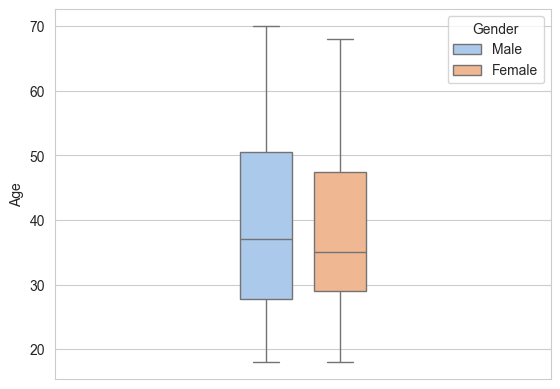

In [9]:
sns.boxplot(y="Age", data=df, width=0.3, hue='Gender', gap=.3)

Possiamo notare come le distribuzioni siano simili, ma con il genere femminile leggermente più compatto a livello di età.

<Axes: ylabel='Salary'>

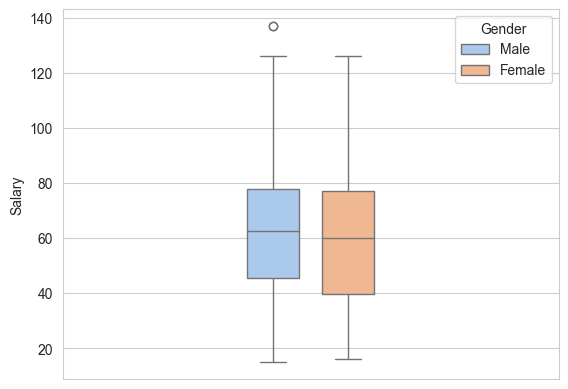

In [10]:
sns.boxplot(y="Salary", data=df, width=0.3, hue='Gender', gap=.3)

Non osserviamo degli outlier particolari. Come valori, notiamo come gli stipendi femminili abbiano una distribuzione simile, ma con una coda a sinistra (quindi sotto la mediana) leggermente più accentuata.

<Axes: ylabel='Score'>

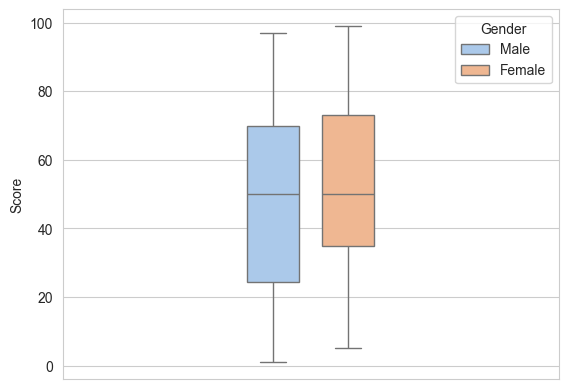

In [11]:
sns.boxplot(y="Score", data=df, width=0.3, hue='Gender', gap=.3)

Anche qui non notiamo degli outlier e le distribuzioni sono simili, con il genere femminile che sembra tendere a spendere un pochino di più rispetto al maschile.

### 1.3.3 Trasformazione

Per lo scopo di questo esercizio, non abbiamo necessità di modificare le unità di misura. Tuttavia, per pura pratica, convertiamo gli stipendi da dollari ad euro:

In [12]:
df['Salary'] = df['Salary'] * 0.94
df

Gender  Age  Salary  Score
0      Male   19   14.10     39
1      Male   21   14.10     81
2    Female   20   15.04      6
3    Female   23   15.04     77
4    Female   31   15.98     40
..      ...  ...     ...    ...
195  Female   35  112.80     79
196  Female   45  118.44     28
197    Male   32  118.44     74
198    Male   32  128.78     18
199    Male   30  128.78     83

[200 rows x 4 columns]

Sicuramente abbiamo bisogno di convertire la feature Gender in numerica. Possiamo applicare un one hot encoder tramite il metodo get_dummies() per semplicità:

In [13]:
df = df.join(pd.get_dummies(df['Gender']))
df

Gender  Age  Salary  Score  Female   Male
0      Male   19   14.10     39   False   True
1      Male   21   14.10     81   False   True
2    Female   20   15.04      6    True  False
3    Female   23   15.04     77    True  False
4    Female   31   15.98     40    True  False
..      ...  ...     ...    ...     ...    ...
195  Female   35  112.80     79    True  False
196  Female   45  118.44     28    True  False
197    Male   32  118.44     74   False   True
198    Male   32  128.78     18   False   True
199    Male   30  128.78     83   False   True

[200 rows x 6 columns]

In [14]:
df.drop('Male', axis=1, inplace=True)
df.drop('Gender', axis=1, inplace=True)
female_col = df.pop('Female')
df.insert(0, 'Female', female_col)
df

Female  Age  Salary  Score
0     False   19   14.10     39
1     False   21   14.10     81
2      True   20   15.04      6
3      True   23   15.04     77
4      True   31   15.98     40
..      ...  ...     ...    ...
195    True   35  112.80     79
196    True   45  118.44     28
197   False   32  118.44     74
198   False   32  128.78     18
199   False   30  128.78     83

[200 rows x 4 columns]

# 2 HC: dataset ridotto

Per un primo esempio, concentriamoci solamente su stipendio e spending score:

In [15]:
df_red = df.copy()
df_red.drop(['Female', 'Age'], axis=1, inplace=True)
df_red

Salary  Score
0     14.10     39
1     14.10     81
2     15.04      6
3     15.04     77
4     15.98     40
..      ...    ...
195  112.80     79
196  118.44     28
197  118.44     74
198  128.78     18
199  128.78     83

[200 rows x 2 columns]

## 2.1 Train/test split

Con il clustering non è necessario! Non è una tecnica di tipo supervised.

## 2.2 Feature scaling

In questo caso, dobbiamo implementare il feature scaling. Spesso, si ricorre alla standardizzazione e, a meno di casi particolari, faremo così nel corso. Procediamo come visto in questo ordine:
- creazione di un oggetto StandardScaler
- applicazione del metodo fit_transform() sul training set
- applicazione del metodo transform() (senza fit!) sul test set

Ricordiamo di non scalare la feature booleana, se dovesse essere presente nelle feature selezionate.


In [16]:
sc = StandardScaler()
X = sc.fit_transform(df_red)
X

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992],
       [-1.66266033,  1.00159627],
       [-1.62449091, -1.71591298],
       [-1.62449091,  1.70038436],
       [-1.58632148, -1.83237767],
       [-1.58632148,  0.84631002],
       [-1.58632148, -1.4053405 ],
       [-1.58632148,  1.89449216],
       [-1.54815205, -1.36651894],
       [-1.54815205,  1.04041783],
       [-1.54815205, -1.44416206],
       [-1.54815205,  1.11806095],
       [-1.50998262, -0.59008772],
       [-1.50998262,  0.61338066],
       [-1.43364376, -0.82301709],
       [-1.43364376,  1.8556706 ],
       [-1.39547433, -0.59008772],
       [-1.39547433,  0.88513158],
       [-1.3573049 , -1.75473454],
       [-1.3573049 ,  0.88513158],
       [-1.24279661, -1.4053405 ],
       [-1.24279661,  1.23452563],
       [-1.24279661, -0.7065524 ],
       [-1.24279661,  0.41927286],
       [-1.20462718,

Possiamo prima di tutto calcolare la matrice Z tramite il metodo [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) del modulo scipy: 

In [17]:
Z = hierarchy.linkage(X, method = 'complete')
Z

array([[6.50000000e+01, 6.80000000e+01, 0.00000000e+00, 2.00000000e+00],
       [4.80000000e+01, 4.90000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.29000000e+02, 1.31000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.56000000e+02, 1.58000000e+02, 0.00000000e+00, 2.00000000e+00],
       [6.30000000e+01, 2.00000000e+02, 3.81694292e-02, 3.00000000e+00],
       [1.70000000e+02, 1.74000000e+02, 3.81694292e-02, 2.00000000e+00],
       [9.20000000e+01, 9.90000000e+01, 3.81694292e-02, 2.00000000e+00],
       [9.40000000e+01, 9.80000000e+01, 3.81694292e-02, 2.00000000e+00],
       [1.07000000e+02, 1.13000000e+02, 3.81694292e-02, 2.00000000e+00],
       [5.10000000e+01, 5.30000000e+01, 3.81694292e-02, 2.00000000e+00],
       [1.01000000e+02, 1.09000000e+02, 3.81694292e-02, 2.00000000e+00],
       [2.10000000e+01, 2.30000000e+01, 3.81694292e-02, 2.00000000e+00],
       [1.51000000e+02, 1.55000000e+02, 3.88215607e-02, 2.00000000e+00],
       [1.50000000e+02, 1.54000000e+02, 3.88215607e

Viene fornita una matrice con 4 colonne:
- colonne 0-1: indici dei cluster che sono stati uniti in quello step. Le foglie sono numerate da $1$ a $N$, ma vi saranno indici ben superiori a $N$ in quanto si dovranno numerare anche i nuovi cluster (nodi) ottenuti nella creazione dell'albero;
- colonna 2: distanza tra i due cluster uniti in quello step;
- colonna 3: numero di osservazioni originali contenute nel cluster appena formato.

Si potrebbe applicare anche in questo caso un elbow method andando a mostrare le distanze tra i cluster presenti nella colonna con indice 2 (la terza) dell'array Z:

Text(0, 0.5, 'Variation in cluster distance')

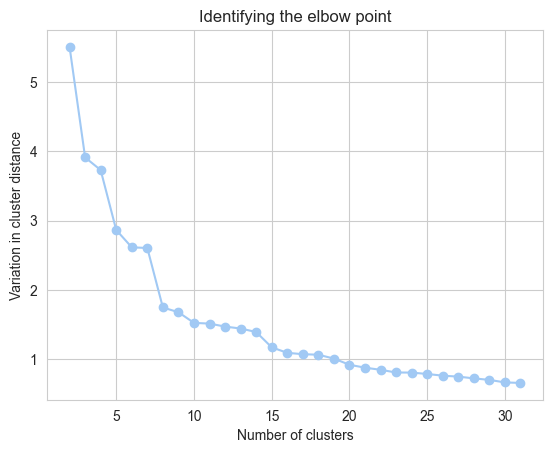

In [18]:
distances = Z[-30:, 2]  # prendiamo gli ultimi 30 elementi, ovvero le ultime 30 unioni
num_clusters = np.arange(31, 1, -1)  # il numero di cluster è 1 per il primo elemento e poi ad aumentare
plt.plot(num_clusters, distances, marker='o')
plt.title('Identifying the elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Variation in cluster distance')

Dal grafico, due possibili opzioni sono 5 o 8 cluster...lasciamo un attimo in sospeso per vedere il dendrogramma, poi valutiamo anche la silhouette che ci fornisce spesso delle indicazioni più precise.

Ora possiamo chiamare la funzione [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) che fornisce il grafico del dendrogramma:

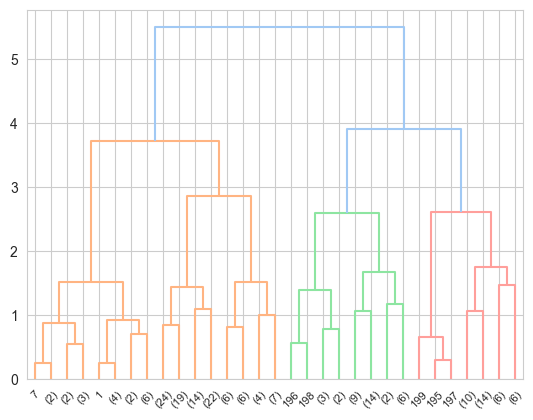

In [19]:
dendrogram = hierarchy.dendrogram(Z, p=4, truncate_mode = 'level')

Per valutare il dendrogramma, può essere utile valutare la silhouette. Per calcolare i cluster, ricorriamo alla classe [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html):

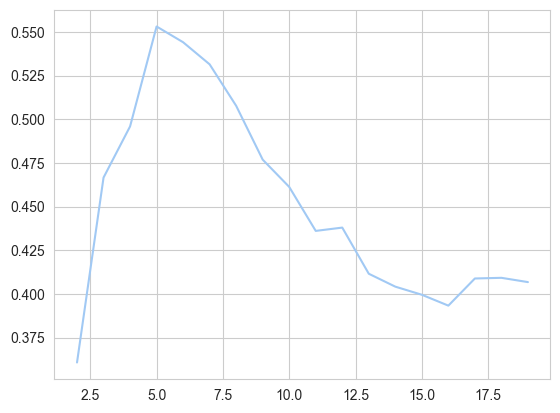

In [20]:
score = []
n_clust = []
for i in range(2, 20):
    hc = AgglomerativeClustering(n_clusters = i, metric = 'euclidean', linkage = 'complete')
    labels = hc.fit_predict(X)
    n_clust.append(i)
    score.append(silhouette_score(X, labels))
plt.plot(n_clust,score)

Come con il k-means, il numero ottimo di cluster è 5. Prendamo le label e valutiamo i cluster:

In [21]:
hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'complete')
labels = hc.fit_predict(X)
labels

array([1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0])

## 2.3 Analisi dei risultati

Prendiamo una copia del dataset di partenza e aggiungiamo le label:

In [22]:
df_clus = df.copy()
df_clus["cluster"] = labels
df_clus.head(5)

Female  Age  Salary  Score  cluster
0   False   19   14.10     39        1
1   False   21   14.10     81        3
2    True   20   15.04      6        1
3    True   23   15.04     77        3
4    True   31   15.98     40        1

Ricaviamo gli andamenti medi delle feature per cluster:

In [23]:
df_clus.groupby('cluster').mean()

Female        Age     Salary      Score
cluster                                           
0        0.538462  32.692308  81.346154  82.128205
1        0.608696  45.217391  24.726087  20.913043
2        0.473684  40.394737  81.780000  18.631579
3        0.571429  25.333333  23.589524  80.047619
4        0.594937  42.886076  51.152658  50.215190

Possiamo notare che abbiamo ottenuto dei cluster assolutamente in linea con quelli del k-means, con al più la numerazione modificata. Visualizziamo i cluster:

<Axes: xlabel='Score', ylabel='Salary'>

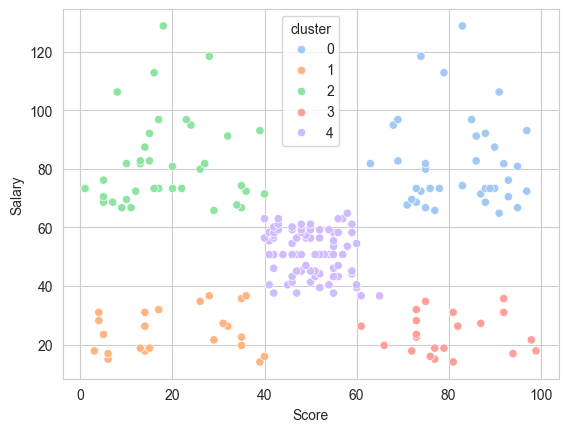

In [24]:
sns.scatterplot(data=df_clus, x="Score", y="Salary", hue="cluster", palette="pastel")

# 3 HC: 3 feature

Includiamo l'età nel clustering:

In [25]:
df_red = df.copy()
df_red.drop(['Female'], axis=1, inplace=True)
df_red

Age  Salary  Score
0     19   14.10     39
1     21   14.10     81
2     20   15.04      6
3     23   15.04     77
4     31   15.98     40
..   ...     ...    ...
195   35  112.80     79
196   45  118.44     28
197   32  118.44     74
198   32  128.78     18
199   30  128.78     83

[200 rows x 3 columns]

Eseguiamo il feature scaling:

In [26]:
sc = StandardScaler()
X = sc.fit_transform(df_red)
X

array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992],
       [-1.20926872, -1.66266033,  1.00159627],
       [-0.27630176, -1.62449091, -1.71591298],
       [-1.13750203, -1.62449091,  1.70038436],
       [ 1.80493225, -1.58632148, -1.83237767],
       [-0.6351352 , -1.58632148,  0.84631002],
       [ 2.02023231, -1.58632148, -1.4053405 ],
       [-0.27630176, -1.58632148,  1.89449216],
       [ 1.37433211, -1.54815205, -1.36651894],
       [-1.06573534, -1.54815205,  1.04041783],
       [-0.13276838, -1.54815205, -1.44416206],
       [-1.20926872, -1.54815205,  1.11806095],
       [-0.27630176, -1.50998262, -0.59008772],
       [-1.3528021 , -1.50998262,  0.61338066],
       [ 0.94373197, -1.43364376, -0.82301709],
       [-0.27630176, -1.43364376,  1.8556706 ],
       [-0.27630176, -1.39547433, -0.590

Applichiamo l'elbow method e osserviamo la silhouette per il valore ottimo di $k$:

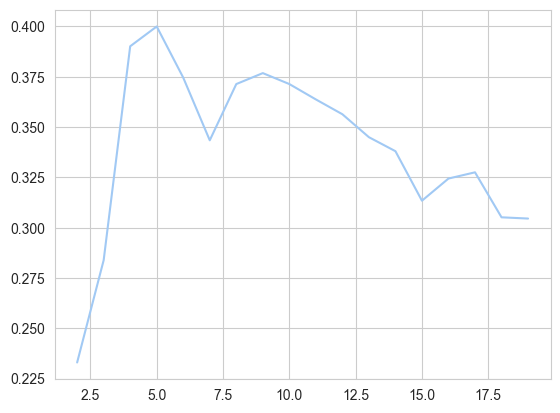

In [27]:
score = []
n_clust = []
for i in range(2, 20):
    hc = AgglomerativeClustering(n_clusters = i, metric = 'euclidean', linkage = 'complete')
    labels = hc.fit_predict(X)
    n_clust.append(i)
    score.append(silhouette_score(X, labels))
plt.plot(n_clust,score)

Text(0, 0.5, 'Variation in cluster distance')

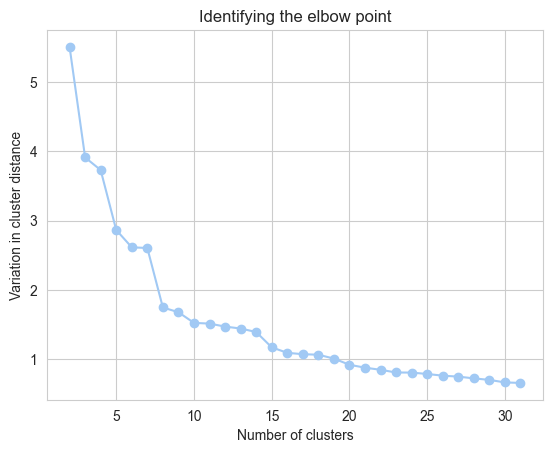

In [28]:
distances = Z[-30:, 2]  # prendiamo gli ultimi 30 elementi, ovvero le ultime 30 unioni
num_clusters = np.arange(31, 1, -1)  # il numero di cluster è 1 per il primo elemento e poi ad aumentare
plt.plot(num_clusters, distances, marker='o')
plt.title('Identifying the elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Variation in cluster distance')

E' interessante notare come il numero ottimo di cluster in questo caso sia ancora 5:

In [29]:
hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'complete')
labels = hc.fit_predict(X)
labels

array([0, 4, 0, 4, 0, 4, 0, 4, 2, 4, 2, 4, 2, 4, 0, 4, 0, 4, 2, 4, 0, 4,
       2, 4, 2, 4, 2, 0, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 0,
       2, 4, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3,
       0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3])

In [30]:
df_clus = df.copy()
df_clus["cluster"] = labels
df_clus.head(5)

Female  Age  Salary  Score  cluster
0   False   19   14.10     39        0
1   False   21   14.10     81        4
2    True   20   15.04      6        0
3    True   23   15.04     77        4
4    True   31   15.98     40        0

Osserviamo i trend in funzione del cluster:

In [31]:
df_clus.groupby('cluster').mean()

Female        Age     Salary      Score
cluster                                           
0        0.645833  28.354167  47.274167  45.937500
1        0.428571  41.685714  82.934857  17.285714
2        0.561404  55.333333  44.476842  41.087719
3        0.538462  32.692308  81.346154  82.128205
4        0.619048  24.809524  24.081905  80.238095

Visualizziamo i cluster in 3D:

Text(0.5, 0, 'Score')

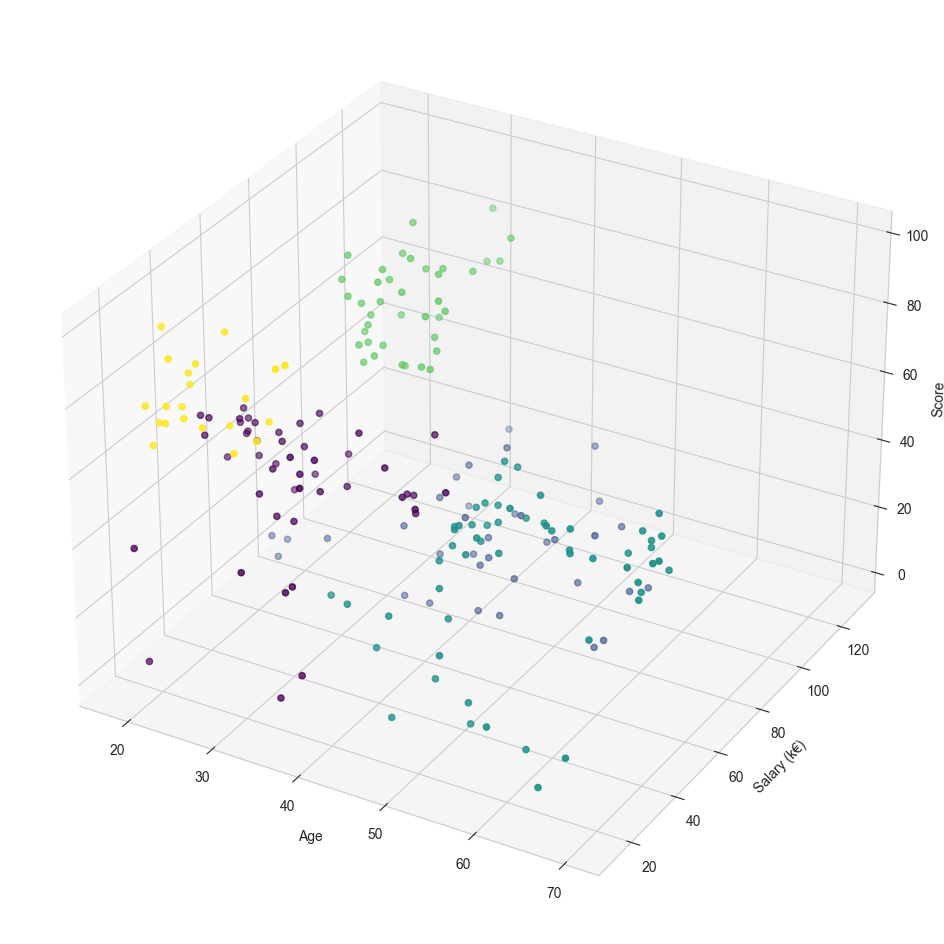

In [32]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_clus['Age'], df_clus['Salary'], df_clus['Score'],c=df_clus['cluster'], cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Salary (k€)')
ax.set_zlabel('Score')

Potrebbe essere interessante dividere il dataset in 2 sotto-insiemi in base al genere e ripetere il clustering con 3 feature. Questo consentirebbe al management del centro commenrciale di definire delle campagne di marketing ancora più mirate.